<a href="https://colab.research.google.com/github/Mobad225/Housing-Prices-Regression/blob/master/Housing_prices_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Downloading the dataset

In [0]:
import os
import tarfile
import urllib

DOWNLOAD_ROOT = 'https://raw.githubusercontent.com/ageron/handson-ml2/master/'
HOUSING_PATH = os.path.join('datasets', 'housing')
HOUSING_URL = DOWNLOAD_ROOT + 'datasets/housing/housing.tgz'

def fetch_housing_data(housing_url = HOUSING_URL, housing_path = HOUSING_PATH):
  os.makedirs(housing_path, exist_ok = True)
  tgz_path = os.path.join(housing_path, 'housing.tgz')
  urllib.request.urlretrieve(housing_url, tgz_path)
  housing_tgz = tarfile.open(tgz_path)
  housing_tgz.extractall(path = housing_path)
  housing_tgz.close()

In [0]:
fetch_housing_data()

# Load the data using Pandas

In [0]:
import pandas as pd

def load_data(housing_path = HOUSING_PATH):
  csv_path = os.path.join(housing_path, 'housing.csv')
  return pd.read_csv(csv_path)

In [0]:
housing = load_data()

In [0]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


### Since ocean_proximity is an object (String because it is read from .csv), I should check it more.

In [0]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

### Also to look at numerical fields

In [0]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


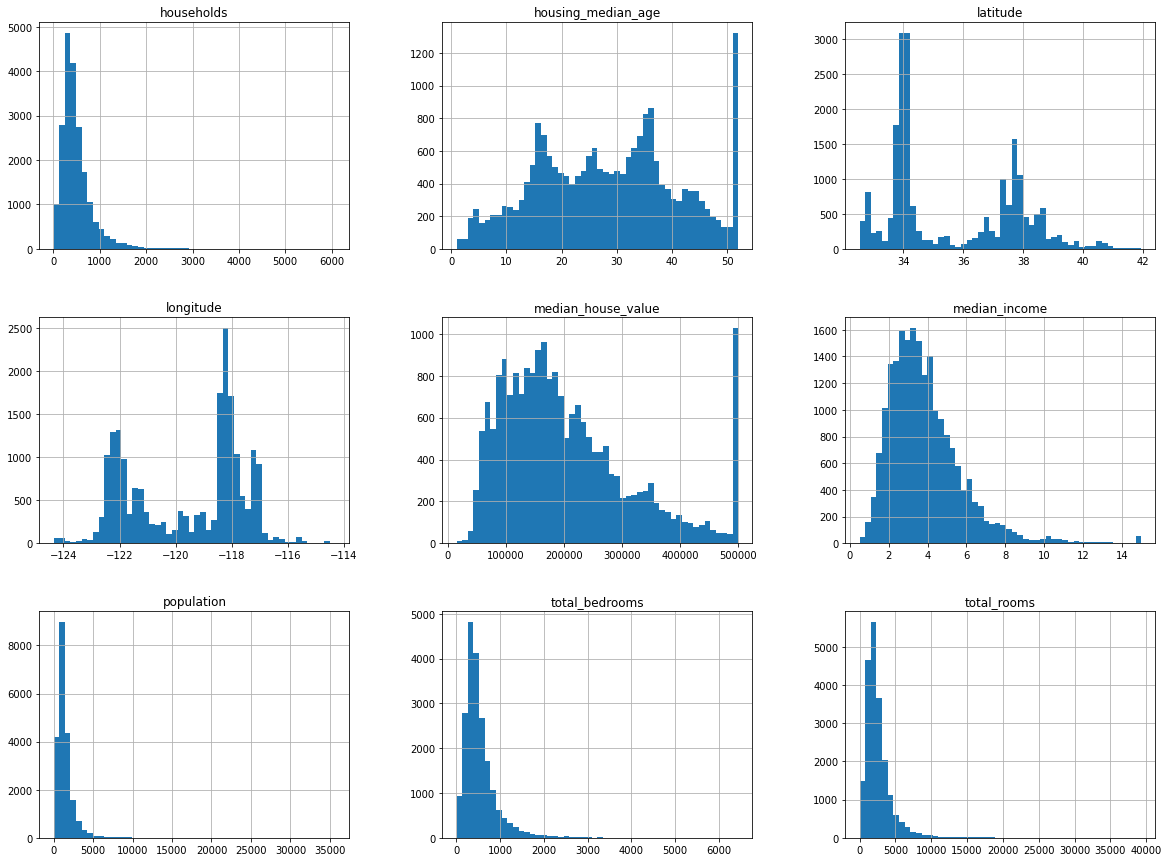

In [0]:
import matplotlib.pyplot as plt
housing.hist(bins = 50, figsize=(20, 15))
plt.show()

## A good way to split train/test data using hashing

In [0]:
import numpy as np
from zlib import crc32

def test_set_check(id, test_ratio):
  return crc32(np.int64(id)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_col):
  ids = data[id_col]
  in_test_set = ids.apply(lambda id_ : test_set_check(id_, test_ratio))
  return data.loc[~in_test_set], data.loc[in_test_set]

### Adding an ID column, then splitting using the hash of ID column

In [0]:
housing_with_id = housing.reset_index()
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, 'index')

In [0]:
print(len(train_set), '\t', len(test_set))

16512 	 4128


## Since Median Income is very important, I need to make sure the train and test sets are representitive of the different strata in that attribute

### Looking at the histogram of that attribute

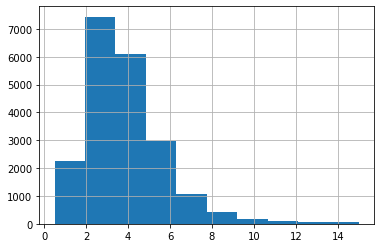

In [0]:
housing['median_income'].hist()
plt.show()

### Since it is continious data, I will need to represent the strata in a new feature.
### I will split the data such that:
### 0 < median_income <= 1.5 will be strata **1**
### 1.5 < median_income <= 3 will be strata **2**
### 3 < median_income <= 4.5 will be strata **3**
### 4.5 < median_income <= 6 will be strata **4**
### 6 < median_income <= infinity will be strata **5**  

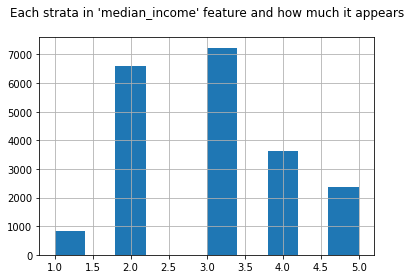

In [0]:
housing['income_stratum'] = pd.cut(housing['median_income'],
                                   bins = [0, 1.5, 3, 4.5, 6, np.inf],
                                   labels = [1, 2, 3, 4, 5])
housing['income_stratum'].hist()
plt.title("Each strata in 'median_income' feature and how much it appears\n")
plt.show()

## Now since I have the strata seperated, I can do a Stratified Split!

In [0]:
from sklearn.model_selection import StratifiedShuffleSplit

ss_split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)
for train_ind, test_ind in ss_split.split(housing, housing['income_stratum']): #.split returns n_splits arrays of indices for train & test
  strat_train_set = housing.loc[train_ind]
  strat_test_set = housing.loc[test_ind]

#Check for each strata, Percentage in dataset and percentage in test set!

in_test = strat_test_set['income_stratum'].value_counts() / len(strat_test_set)
in_data = housing['income_stratum'].value_counts() / len(housing)

"""
To compare to old split (Just using hashing), I will add the same column to the old
Test set (test_set) and print the percentage of the bins as well!
I will delete the colum after that
"""

test_set['income_stratum'] = pd.cut(test_set['median_income'],
                                   bins = [0, 1.5, 3, 4.5, 6, np.inf],
                                   labels = [1, 2, 3, 4, 5])

in_old_test = test_set['income_stratum'].value_counts() / len(test_set)

test_set = test_set.drop(columns = 'income_stratum', axis = 1)

#test_set.info() #Was using it to make sure the column is deleted


print('In Test set\n', in_test * 100, sep = '', end = '\n\n')
print('In Data set\n', in_data * 100, sep = '', end = '\n\n')
print('In Old test set\n', in_old_test * 100, sep = '', end = '\n\n')

#Looks great!!

In Test set
3    35.053295
2    31.879845
4    17.635659
5    11.458333
1     3.972868
Name: income_stratum, dtype: float64

In Data set
3    35.058140
2    31.884690
4    17.630814
5    11.443798
1     3.982558
Name: income_stratum, dtype: float64

In Old test set
3    34.714147
2    33.066860
4    16.860465
5    11.991279
1     3.367248
Name: income_stratum, dtype: float64



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## Now I will remove the extra column to reach original format

In [0]:
#Will throw error if rerun, and columns are already dropped
strat_test_set.drop('income_stratum', axis = 1, inplace= True)
strat_train_set.drop('income_stratum', axis = 1, inplace= True)

## More Visualing! Training Data of course!

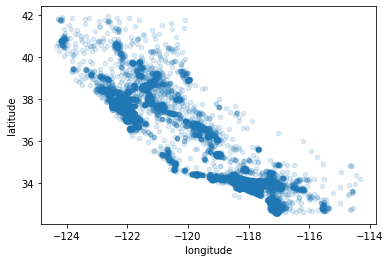

In [0]:
#Creating a copy to play with without changing the training set
housing = strat_train_set.copy()

#Looking at geographical features
housing.plot(kind = 'scatter', x = 'longitude', y = 'latitude', alpha = 0.15)
#Using alpha to easier visualize the places with higher density.
plt.show()

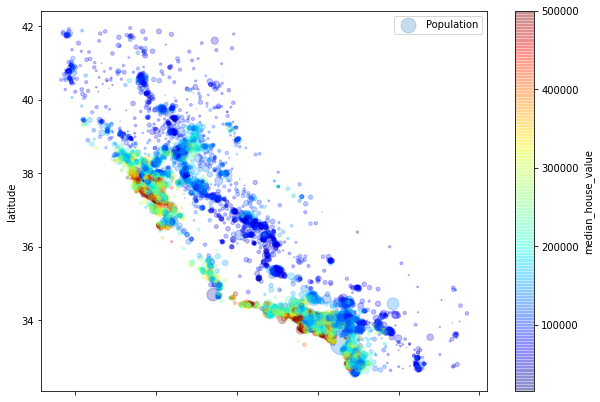

In [0]:
"""
Looking at housing prices (Colour map) & population (Circles radius) with respect to
Geographical position.
"""
housing.plot(kind = 'scatter', x = 'longitude', y = 'latitude', alpha = 0.25, 
             s = housing['population']/80, label = 'Population', figsize = (10, 7),
             c = 'median_house_value', cmap = plt.get_cmap('jet'), colorbar = True)
plt.legend()
plt.show()

## Checking correlation matrix

In [0]:
corr = housing.corr()
corr

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924478,-0.105848,0.048871,0.076598,0.108030,0.063070,-0.019583,-0.047432
latitude,-0.924478,1.000000,0.005766,-0.039184,-0.072419,-0.115222,-0.077647,-0.075205,-0.142724
housing_median_age,-0.105848,0.005766,1.000000,-0.364509,-0.325047,-0.298710,-0.306428,-0.111360,0.114110
total_rooms,0.048871,-0.039184,-0.364509,1.000000,0.929379,0.855109,0.918392,0.200087,0.135097
total_bedrooms,0.076598,-0.072419,-0.325047,0.929379,1.000000,0.876320,0.980170,-0.009740,0.047689
population,0.108030,-0.115222,-0.298710,0.855109,0.876320,1.000000,0.904637,0.002380,-0.026920
households,0.063070,-0.077647,-0.306428,0.918392,0.980170,0.904637,1.000000,0.010781,0.064506
median_income,-0.019583,-0.075205,-0.111360,0.200087,-0.009740,0.002380,0.010781,1.000000,0.687160
median_house_value,-0.047432,-0.142724,0.114110,0.135097,0.047689,-0.026920,0.064506,0.687160,1.000000


In [0]:
"""
Checking correlation of all features with 'median_house_value' which is the feature
we will need to predict later on.
"""
corr_with_val = corr['median_house_value'].sort_values(ascending = False)
print(corr_with_val)
print("\nIts very obvious that 'median_income', 'latitude' & 'total rooms' are important")

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

Its very obvious that 'median_income', 'latitude' & 'total rooms' are important


## Lets plot a scatter matrix to better visualize the relationship of the 'median house value' and the most dominant attributes that affec it

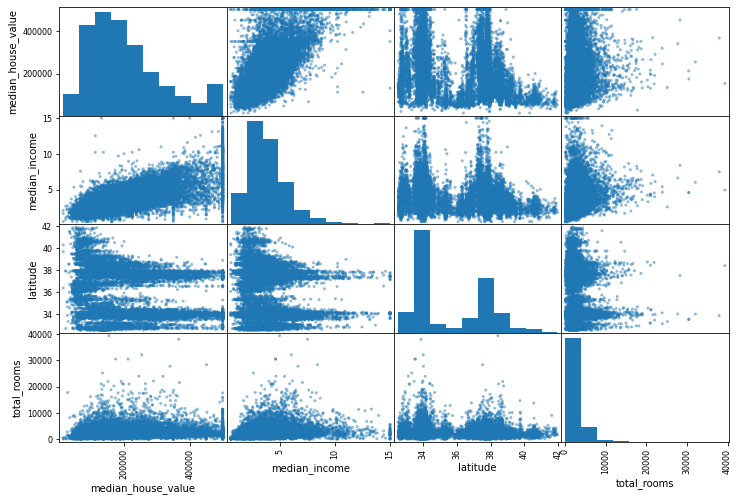

In [0]:
from pandas.plotting import scatter_matrix

attributes = ['median_house_value', 'median_income', 'latitude', 'total_rooms']
s_mat = scatter_matrix(housing[attributes], figsize = (12, 8))
plt.show()

"""
Every attribute scatter plot against every other one except itself, in this case, 
it shows a Histogram of that attribute
""";

### The attribute 'median_income' is very promising, so I will check it out better

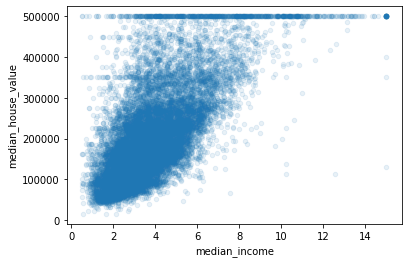

In [0]:
housing.plot(kind = 'scatter', x = 'median_income', y = 'median_house_value', alpha = 0.1)
plt.show()
#Cap at $500,000 doesnt look good, maybe I will need to fix that
#   If i remove the districts where value >= 500k, I should remove from test set too
#Maybe also try to remove the districts that make the horizontal lines @380k & @450k

## Removing all districts with 'median_house_value' >= 500,000
### In train & test sets

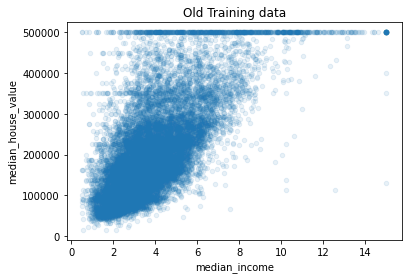

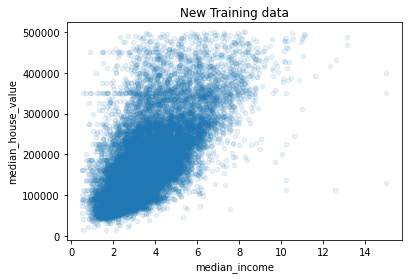

In [0]:
strat_train_set.plot(kind = 'scatter', x = 'median_income', y = 'median_house_value', alpha = 0.1)
plt.title('Old Training data')
plt.show()
plt.close()
print() #For extra line
good_ind = strat_train_set['median_house_value'] < 500000
new_train_set = strat_train_set.loc[good_ind]
new_train_set.plot(kind = 'scatter', x = 'median_income', y = 'median_house_value', alpha = 0.1)
plt.title('New Training data')
plt.show()

#Will do same to test data.
#good_ind = housing

good_ind = strat_test_set['median_house_value'] < 500000
new_test_set = strat_test_set.loc[good_ind]

## Trying to re-do it using a Transformer

In [0]:
from sklearn.base import BaseEstimator, TransformerMixin

class CapRemovalTransformer(BaseEstimator, TransformerMixin):
  def __init__(self, col_name = None, cap = None):
    self.col_name = col_name
    self.cap = cap
  def fit(self, X, y = None):
    return self
  def transform(self, X):
    if self.col_name is None or self.cap is None :
      return
    good_ind = X[self.col_name] < self.cap
    return X.loc[good_ind]

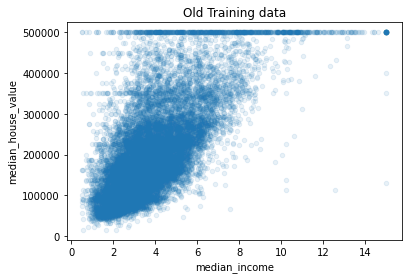

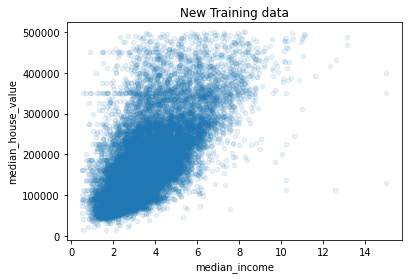

In [0]:
cap_removal_transformer = CapRemovalTransformer('median_house_value', 500000)
new_train_set = cap_removal_transformer.fit_transform(strat_train_set)
new_test_set = cap_removal_transformer.fit_transform(strat_test_set)

#Testing it :)
strat_train_set.plot(kind = 'scatter', x = 'median_income', y = 'median_house_value', alpha = 0.1)
plt.title('Old Training data')
plt.show()
plt.close()
print() #For extra line
new_train_set.plot(kind = 'scatter', x = 'median_income', y = 'median_house_value', alpha = 0.1)
plt.title('New Training data')
plt.show()
#Great

## Making data/labels from the sets (Finally)

In [0]:
#For training data from my latest 'new_train_set' set.
housing = new_train_set.drop('median_house_value', axis = 1)
housing_labels = new_train_set['median_house_value'].copy()

## Using simple Imputer to fill records where 'total_bedrooms' is missing

In [0]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy = 'median')
"""
Since it works with numerical values only, I will remove the string attribute in a
temp dataframe.
I will send all the numerical attributes so if at anytime (Maybe online) another
numerical attribute is missing, I can replace it with THIS median
"""
housing_numerical = housing.drop('ocean_proximity', axis = 1)
imputer.fit(housing_numerical)

#Checking the statistics //Median of each attribute.
print(imputer.statistics_)

[-118.52     34.28     28.     2104.      435.     1177.      410.
    3.4531]


## Using the imputer to fill the missing numerical values

In [0]:
X = imputer.transform(housing_numerical)
print('Return data type = ', type(X))
#It returns np array, so will change it to pd dataframe
housing_tr_numerical = pd.DataFrame(X, columns = housing_numerical.columns, 
                                    index = housing_numerical.index)
housing_tr_numerical.head()

Return data type =  <class 'numpy.ndarray'>


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347


## Will make a transformer that will add 3 more attributes that look like they're important 
###(Actually Their correlation with the 'median_house_value' was tested and they were effective, but since I already removed this feature, so I will skip this)

In [0]:
rooms_ind, bedrooms_ind, population_ind, households_ind = 3, 4, 5, 6

class AttributeAdder(BaseEstimator, TransformerMixin):
  def __init__(self, add_bedrooms_per_room = True):
    self.add_bedrooms_per_room = add_bedrooms_per_room
  def fit(self, X, y = None):
    return self
  def transform(self, X):
    rooms_per_household = X[:, rooms_ind] / X[:, households_ind]
    population_per_household = X[:, population_ind] / X[:, households_ind]
    bedrooms_per_room = X[:, bedrooms_ind] / X[:, rooms_ind]
    if self.add_bedrooms_per_room:
      return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
    return np.c_[X, rooms_per_household, population_per_household]

In [0]:
attribute_adder = AttributeAdder()
housing_extra_attribs = attribute_adder.fit_transform(housing_tr_numerical.values)
housing_tr_numerical = pd.DataFrame(housing_extra_attribs)

In [0]:
housing_tr_numerical.head()
#housing_extra_attribs is the np array
#housing_tr_numerical is a dataframe for better visualization

,0,1,2,3,4,5,6,7,8,9,10
0,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,4.625369,2.094395,0.223852
1,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,6.008850,2.707965,0.159057
2,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,4.225108,2.025974,0.241291
3,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,5.232295,4.135977,0.200866
4,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,4.505810,3.047847,0.231341


## Extra Utility Transformer

In [0]:
class ColumnRemover(BaseEstimator, TransformerMixin):
  def __init__(self, col_name):
    self.col_name = col_name
  def fit(self, X, y = None):
    return self
  def transform(self, X):
    X.drop(self.col_name, axis = 1, inplace = True)
    return X

# Feature Scaling

In [0]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

#Will use a pipeline instead of the previous using of transformers :)
numerical_pipeline = Pipeline([
              ('imputer', SimpleImputer(strategy='median')),
              ('attribs_adder', AttributeAdder()),
              ('std_scaler', StandardScaler())                     
])

#This numerical pipeline will be used later along with another categorical pipeline
#I will send it the columns that are 'numerical' so it works with them only.

### Trying out the numerical_pipeline (Thus preparing a numerical only dataset)

In [0]:
"""
Ill need an earlier version of the dataset (Right after using my CapRemovalTransformer)
~~~~> housing (But I'll still need to take only the numerical fields)
"""
housing_num = housing.drop('ocean_proximity', axis = 1)
housing_num_tr = numerical_pipeline.fit_transform(housing_num)

# Now I have a Transformer that takes a numerical dataset and transforms it into a cleaned, edited & scaled **numerical** training set

## I will now OneHotEncode the 'ocean_proximity' categorical feature (As it has only 5 values)
### If the categorical feature had many possible values, it is a better idea to replace the categorical fields with useful numerical values that are related to the categories.

In [0]:
#Getting the categorical features to test the cat pipeline I will do
housing_cat = housing[['ocean_proximity']] #This way to extract a DF from a DF
housing_cat.head()

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN


In [0]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot #Sparse Scipy Matrix!

<15703x5 sparse matrix of type '<class 'numpy.float64'>'
	with 15703 stored elements in Compressed Sparse Row format>

In [0]:
#To Visualize:
print(cat_encoder.categories_)
housing_cat_1hot.toarray()

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)]


array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.]])

# Making the **FINAL** pipeline
### That is a pipeline of pipelines (numerical & categorical)

In [0]:
from sklearn.compose import ColumnTransformer

num_attributes = list(housing_num)
cat_attributes = list(housing_cat)

print(num_attributes)
print(cat_attributes)

full_pipeline = ColumnTransformer([
          ('numerical', numerical_pipeline, num_attributes),
          ('categorical', OneHotEncoder(), cat_attributes)
])

['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']
['ocean_proximity']


In [0]:
#Now pass the whole training dataset to the pipeline!

housing_prepared = full_pipeline.fit_transform(housing)
#DONE!

# Training a Linear Regression model

In [0]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [0]:
sample_data = housing.iloc[:5]
sample_data_prepared = full_pipeline.transform(sample_data)
sample_labels = housing_labels.iloc[:5]
print('Labels : ', list(sample_labels))
print('Predicted : ', list(np.around(lin_reg.predict(sample_data_prepared), 1)))


Labels :  [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]
Predicted :  [201487.1, 310595.8, 200253.7, 62223.9, 189097.2]


### Checking RMSE

In [0]:
from sklearn.metrics import mean_squared_error

housing_pred = lin_reg.predict(housing_prepared)
lin_reg_mse = mean_squared_error(housing_labels, housing_pred)
lin_reg_rmse = np.sqrt(lin_reg_mse)
print(lin_reg_rmse)

60003.82276241499


## Training a Decision Tree regessor

In [0]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)
housing_pred_tree = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_pred_tree, housing_labels)
tree_rmse = np.sqrt(tree_mse)
print(tree_rmse)
#The model overfit the data!
#Proper Evaluation is using Validation sets, Will do that!

0.0


# Validation using K-fold cross validation

In [0]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels, 
                         scoring = 'neg_mean_squared_error', cv = 10)
tree_rmse = np.sqrt(-scores)
print(list(np.around(tree_rmse, 1)))
print('Mean : ', tree_rmse.mean())
print('Std: ', tree_rmse.std())
#Its actually worse than the linear regression due to the overfitting.

[60817.3, 64160.7, 63920.9, 63939.0, 64936.2, 66526.9, 61734.6, 63053.9, 65547.0, 63588.8]
Mean :  63822.532040834034
Std:  1603.1839784795209


## Trying out Random Forest regressor

In [0]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()

scores_forest = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring = 'neg_mean_squared_error', cv = 10)

forest_rmse = np.sqrt(-scores_forest)
print(list(np.around(forest_rmse, 1)))
print('Mean : ', forest_rmse.mean())
print('Std: ', forest_rmse.std())
#It is actually better

[44707.0, 43463.8, 46016.3, 46619.5, 44257.4, 46721.1, 44594.5, 44317.3, 46655.9, 43909.9]
Mean :  45126.27686721799
Std:  1183.8982592215486


## I will experiment the RandomForestRegressor more, Using GridSearch to fine-tune the hyperparameters

In [0]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [50, 100, 130], 'max_features': [6, 8, 10, 12]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}
]
#Will try 3 * 4 + 2 * 3 combinations and find the best!

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv = 5,
                           scoring = 'neg_mean_squared_error', 
                           return_train_score = True)

grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [0]:
best_params = grid_search.best_params_
print('Best parameters : ', best_params)
"""
Since the best params have n_estimators = 130, which is my max allowed, 
I can try increasing this value and check if results improve
"""

#Here is the best estimator :)
grid_search.best_estimator_

Best parameters :  {'max_features': 8, 'n_estimators': 130}


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=8, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=130, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

## Checking Mean of RMSE scores for each Paramter combination

In [0]:
cv_scores = grid_search.cv_results_
for mean_score, params in zip(cv_scores['mean_test_score'], cv_scores['params']):
  print(np.sqrt(-mean_score), params)

45054.22879417575 {'max_features': 6, 'n_estimators': 50}
44840.22758931757 {'max_features': 6, 'n_estimators': 100}
44624.34705607886 {'max_features': 6, 'n_estimators': 130}
44846.676336898025 {'max_features': 8, 'n_estimators': 50}
44657.85640770423 {'max_features': 8, 'n_estimators': 100}
44491.77178478467 {'max_features': 8, 'n_estimators': 130}
44921.902969416355 {'max_features': 10, 'n_estimators': 50}
44812.71635311811 {'max_features': 10, 'n_estimators': 100}
44644.83660592954 {'max_features': 10, 'n_estimators': 130}
45208.181507038564 {'max_features': 12, 'n_estimators': 50}
44875.56182408217 {'max_features': 12, 'n_estimators': 100}
44755.41181223193 {'max_features': 12, 'n_estimators': 130}
56705.000045751294 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
49062.88530300336 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
53906.3425468255 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
47689.880357924514 {'bootstrap': False, 'max_features':

## Checking feature importance for all features

In [0]:
feature_importances = grid_search.best_estimator_.feature_importances_
added_attribs = ['rooms_per_hhold', 'pop_per_hhold', 'bedrooms_per_room']
cat_1hot_attribs = list(full_pipeline.named_transformers_['categorical'].categories_[0])
attributes = num_attributes + added_attribs + cat_1hot_attribs
sorted(zip(feature_importances, attributes), reverse = True)
#Maybe I need to drop the less useful features

[(0.3280404689812995, 'median_income'),
 (0.176515114813561, 'INLAND'),
 (0.10606501870692918, 'pop_per_hhold'),
 (0.08185348821673075, 'longitude'),
 (0.07148724831844648, 'latitude'),
 (0.06209643642990666, 'bedrooms_per_room'),
 (0.04238448788263366, 'housing_median_age'),
 (0.0423616634535806, 'rooms_per_hhold'),
 (0.017862537770391925, 'total_bedrooms'),
 (0.017771440502566974, 'total_rooms'),
 (0.017280760726944712, 'population'),
 (0.016283261571781157, 'households'),
 (0.012857338117845798, '<1H OCEAN'),
 (0.00441297130750232, 'NEAR OCEAN'),
 (0.0026229540950680817, 'NEAR BAY'),
 (0.00010480910481106402, 'ISLAND')]

# Evaluating on Test Set!

In [0]:
final_model = grid_search.best_estimator_

X_test = new_test_set.drop('median_house_value', axis = 1)
y_test = new_test_set['median_house_value'].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

In [0]:
final_mse = mean_squared_error(final_predictions, y_test)
final_rmse = np.sqrt(final_mse)
print("Final RMSE = ", final_rmse)

Final RMSE =  43200.860176909446


## I will check the 95% Confidence Interval for the RMSE
### Will get the range where I am 95% confident the error will be

In [0]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1, 
        loc = squared_errors.mean(), scale = stats.sem(squared_errors)))

array([41327.98852572, 44995.8443022 ])